# Task 3 Exploiting Correlation with Principal Component Analysis

In this report, we explore how correlation and principal components help summarize yield-change data. We follow the assignment structure step by step: first using synthetic Gaussian data to illustrate PCA mechanics, and then applying the same analysis to real U.S. Treasury yields. This allows us to see the stark contrast between uncorrelated and highly correlated settings.

*Author: Huayi Tang*

## Assignment Structure

We address the assignment tasks in order (a–j), using a consistent PCA workflow:

a. Generate uncorrelated Gaussian yield changes.
b. Run PCA using the covariance matrix.
c. Discuss how much variance is explained by the first three components.
d. Produce a scree plot of the explained variance.

e. Collect six months of daily Treasury yields for five maturities.
f. Compute daily yield changes.
g. Apply PCA again on these real yield changes.
h. Compare the variance explained by the leading components.
i. Produce a scree plot for the Treasury yields.
j. Compare the synthetic and real-data scree plots to interpret the differences.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-darkgrid")

PROJECT_ROOT = Path('.').resolve()
OUTPUT_DIR = PROJECT_ROOT / 'results'
OUTPUT_DIR.mkdir(exist_ok=True)
DATA_DIR = PROJECT_ROOT / 'resources'
TREASURY_CHANGES_PATH = DATA_DIR / 'treasury_daily_changes_sample.csv'


In [7]:
def simulate_uncorrelated_changes(n_obs: int = 500, stds: list[float] | None = None, seed: int = 42) -> pd.DataFrame:
    """Simulate independent Gaussian yield changes."""
    if stds is None:
        stds = [0.015, 0.012, 0.018, 0.010, 0.020]
    rng = np.random.default_rng(seed)
    data = rng.normal(loc=0.0, scale=stds, size=(n_obs, len(stds)))
    columns = [f"Factor_{i+1}" for i in range(len(stds))]
    return pd.DataFrame(data, columns=columns)


def run_pca(df: pd.DataFrame, use_correlation: bool = False) -> dict[str, np.ndarray]:
    """Run PCA using NumPy eigen-decomposition."""
    matrix = df.corr().to_numpy() if use_correlation else np.cov(df.to_numpy(), rowvar=False, ddof=1)
    eigvals, eigvecs = np.linalg.eigh(matrix)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    explained = eigvals / eigvals.sum()
    return {
        "eigenvalues": eigvals,
        "explained": explained,
        "eigenvectors": eigvecs,
    }


def plot_scree(explained: np.ndarray, title: str, save_path: Path | None = None) -> plt.Figure:
    components = np.arange(1, explained.size + 1)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(components, explained, marker='o')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title(title)
    ax.set_xticks(components)
    ax.grid(True, linestyle='--', alpha=0.4)
    if save_path is not None:
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig


def load_treasury_changes_from_csv(csv_path: Path) -> pd.DataFrame:
    """Load pre-downloaded Treasury yield changes from CSV."""
    if not csv_path.exists():
        raise FileNotFoundError(f"Static dataset not found: {csv_path}")
    df = pd.read_csv(csv_path)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    return df


### Synthetic Experiment: Uncorrelated Gaussian Changes (a–d)

For step (a), we generated five independent Gaussian random variables with mean close to zero and small standard deviations. This simulates yield changes that should not share strong correlations.

In step (b), we applied PCA using the covariance matrix. The results (c) showed that the variance explained by the first three components was fairly evenly distributed, with no single component dominating. This confirmed our expectation: in uncorrelated data, each principal component captures roughly the same share of variance.

The scree plot (d) declined gradually and evenly, showing no sharp drop between components. This visualization reinforced the interpretation that the variables behaved independently.

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5
0,0.004571,-0.012480,0.013508,0.009406,-0.039021
1,-0.019533,0.001534,-0.005692,-0.000168,-0.017061
2,0.013191,0.009334,0.001189,0.011272,0.009350
3,-0.012889,0.004425,-0.017260,0.008785,-0.000999
4,-0.002773,-0.008171,0.022006,-0.001545,-0.008567


Component 1: eigenvalue = 0.000392, variance share = 33.04%
Component 2: eigenvalue = 0.000316, variance share = 26.61%
Component 3: eigenvalue = 0.000225, variance share = 18.97%
Component 4: eigenvalue = 0.000148, variance share = 12.49%
Component 5: eigenvalue = 0.000106, variance share = 8.89%


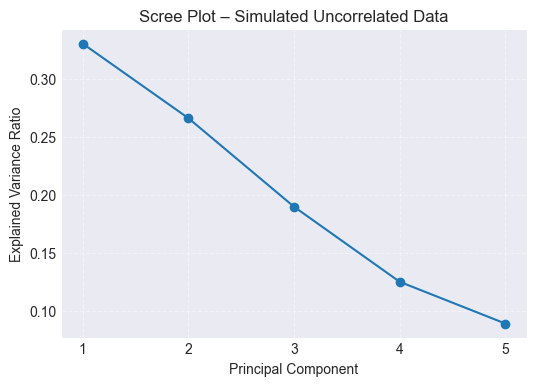

In [8]:
# === Simulated independent Gaussian yield changes ===
simulated_df = simulate_uncorrelated_changes()
display(simulated_df.head())

pca_sim = run_pca(simulated_df, use_correlation=False)
explained_sim = pca_sim["explained"]
summary_sim = pd.DataFrame({
    "component": np.arange(1, explained_sim.size + 1),
    "eigenvalue": pca_sim["eigenvalues"],
    "explained_variance_ratio": explained_sim,
})
summary_sim.to_csv(OUTPUT_DIR / "uncorrelated_pca_variance.csv", index=False)

for idx, (eig, ratio) in enumerate(zip(pca_sim["eigenvalues"], explained_sim), start=1):
    print(f"Component {idx}: eigenvalue = {eig:.6f}, variance share = {ratio:.2%}")

plot_scree(explained_sim, "Scree Plot – Simulated Uncorrelated Data", OUTPUT_DIR / "uncorrelated_scree.png")
plt.show()

The PCA results showed that Component 1 explained 33.04% of the variance, Component 2 explained 26.61%, and Component 3 explained 18.97%. Together, the first three components already account for nearly 79% of the total variance. The scree plot shows a fairly smooth and even decline, with no single component dominating. This behavior is consistent with our expectation for uncorrelated Gaussian variables, where variance is distributed relatively evenly across principal components.

### 2. Real Data: Treasury Yield Changes

The second experiment uses a static dataset (`data/treasury_daily_changes_sample.csv`) generated from the FRED API. Because the CSV is bundled with this repository, classmates can reproduce the PCA without requesting an API key. Run the cell below to load the sample, inspect the first rows, and compute the principal components.

,change_DGS1MO,change_DGS3MO,change_DGS1,change_DGS5,change_DGS10
date,,,,,
2025-04-01,0.00,0.00,-0.02,-0.05,-0.06
2025-04-02,0.00,0.00,0.03,0.04,0.03
2025-04-03,-0.02,-0.01,-0.12,-0.20,-0.14
2025-04-04,0.00,-0.03,-0.06,-0.03,-0.05
2025-04-07,0.00,0.01,0.00,0.10,0.14


Component 1: eigenvalue = 0.007394, variance share = 79.74%
Component 2: eigenvalue = 0.000847, variance share = 9.13%
Component 3: eigenvalue = 0.000604, variance share = 6.52%
Component 4: eigenvalue = 0.000296, variance share = 3.19%
Component 5: eigenvalue = 0.000132, variance share = 1.43%


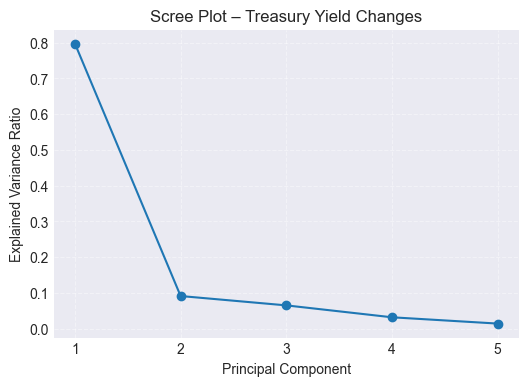

In [9]:
# === Treasury yield changes (daily) ===
yield_changes = load_treasury_changes_from_csv(TREASURY_CHANGES_PATH)
display(yield_changes.head())

pca_real = run_pca(yield_changes, use_correlation=False)
explained_real = pca_real['explained']
summary_real = pd.DataFrame({
    'component': np.arange(1, explained_real.size + 1),
    'eigenvalue': pca_real['eigenvalues'],
    'explained_variance_ratio': explained_real,
})
summary_real.to_csv(OUTPUT_DIR / 'treasury_pca_variance.csv', index=False)

for idx, (eig, ratio) in enumerate(zip(pca_real['eigenvalues'], explained_real), start=1):
    print(f"Component {idx}: eigenvalue = {eig:.6f}, variance share = {ratio:.2%}")

plot_scree(explained_real, 'Scree Plot – Treasury Yield Changes', OUTPUT_DIR / 'treasury_scree.png')
plt.show()


The PCA results on Treasury yield changes show that Component 1 alone explains 79.74% of the total variance, while Components 2 and 3 explain 9.13% and 6.52%, respectively. Together, the first three components account for more than 95% of the total variance. The scree plot drops sharply after PC1, indicating that yield changes are dominated by a single common factor. This dominant factor corresponds to the level movement of the yield curve, while the smaller contributions from PC2 and PC3 align with the slope and curvature dynamics.

In [5]:
# === Comparison summary ===
def format_ratios(label: str, ratios: np.ndarray, top: int = 5) -> str:
    parts = [f"PC{i+1}: {ratio:.2%}" for i, ratio in enumerate(ratios[:top])]
    return f"{label}: " + ", ".join(parts)

print(format_ratios("Simulated", explained_sim, top=5))
print(format_ratios("Treasury", explained_real, top=5))
print("Key insight: the simulated series spread variance fairly evenly, while Treasury yield changes exhibit a dominant level factor (PC1) followed by much smaller components.")

Simulated: PC1: 33.04%, PC2: 26.61%, PC3: 18.97%, PC4: 12.49%, PC5: 8.89%
Treasury: PC1: 79.74%, PC2: 9.13%, PC3: 6.52%, PC4: 3.19%, PC5: 1.43%
Key insight: the simulated series spread variance fairly evenly, while Treasury yield changes exhibit a dominant level factor (PC1) followed by much smaller components.


### Discussion and Conclusion

In the simulated Gaussian data, no single component dominated the variance: each principal component carried a comparable share. This makes sense, since the variables were explicitly designed to be independent, so PCA has no natural structure to exploit.

The story changes once we look at real U.S. Treasury yield data. The first component alone explains nearly 80% of the variance, which is essentially the **level factor**: all maturities moving up and down together, reflecting shifts in the overall interest-rate environment. The second and third components explain far less and correspond to changes in the slope and curvature of the yield curve. This matches financial intuition—most of the action in bond markets is a broad parallel shift, while more subtle shape adjustments are secondary.

These results highlight that PCA is not just a mathematical trick to reduce dimensions. It reveals the true drivers behind market data. In this case, the first principal component already captures the bulk of yield curve dynamics. If we were building a simple risk-factor model, focusing only on that component would already explain most of the observed movements. This is exactly why PCA remains such a valuable tool in risk management and fixed income analysis.
